# Titanic competition 

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC

## Load data and split it into features and labels

In [2]:
train_input = pd.read_csv("kaggle/input/titanic/train.csv")
test_input = pd.read_csv("kaggle/input/titanic/test.csv")

In [3]:
train_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data_train = train_input.iloc[:, 2:]
data_train.shape

(891, 10)

In [5]:
labels_train = train_input["Survived"]
labels_train.shape

(891,)

In [6]:
data_test = test_input.iloc[:, 1:]
data_test.shape

(418, 10)

## Data preparation

Check if cabins provide some insights

In [7]:
data_train["Cabin"].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [8]:
cabins = data_train["Cabin"].replace(np.NaN, "U").str[0]
cabins

0      U
1      C
2      U
3      C
4      U
      ..
886    U
887    B
888    U
889    C
890    U
Name: Cabin, Length: 891, dtype: object

<Axes: title={'center': 'Likelihood of survival based on the cabin class'}, xlabel='Cabin class', ylabel='Survival rate'>

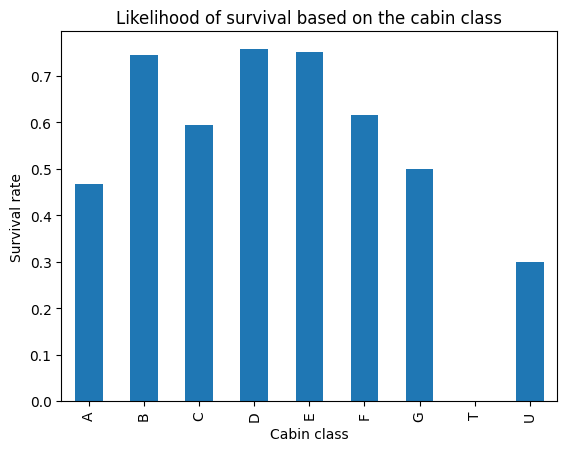

In [9]:
df = pd.concat([cabins, labels_train], axis=1)
survivors = df.groupby("Cabin").sum()
total = df.groupby("Cabin").count()
survival_rate = survivors / total
survival_rate.plot(
    kind="bar",
    xlabel="Cabin class",
    ylabel="Survival rate",
    title="Likelihood of survival based on the cabin class",
    legend=False,
)

Nobody from cabins starting with T survived, while cabins B, D and E have higher survival rate.
People with unknown cabins also had lower survival rate.
Let's add this information to the main frame.

## Creating pipelines

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


In [11]:
def extract_cabin_class(cabins):
    cabin_classes = cabins.replace(np.NaN, "U").str[0]
    ord_enc = OrdinalEncoder()
    return ord_enc.fit_transform(cabin_classes.array.reshape(-1, 1))

In [12]:
numerical_pipeline = Pipeline(
    steps=[('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())]
)

categorical_pipeline = Pipeline(
    steps=[
        ('ord_encode', OrdinalEncoder()),
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('oh_encode', OneHotEncoder(sparse_output=False)),
    ]
)

In [13]:
columns_to_drop = ["Name", "Ticket"]  # Name and Ticket are too random
numerical_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_columns = ["Sex", "Embarked"]

preprocessing = ColumnTransformer(
    transformers=[
        ("columns_dropper", "drop", columns_to_drop),
        ("numerical_transformer", numerical_pipeline, numerical_columns),
        ("categorical_transformer", categorical_pipeline, categorical_columns),
        ("cabins_transformer", FunctionTransformer(extract_cabin_class), "Cabin"),
    ]
)

In [14]:
data_train_processed = preprocessing.fit_transform(data_train)

## Model selection

In [15]:
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=4,
)

cross_val_score(
    rfc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8148689138576779

In [16]:
knc = KNeighborsClassifier(
    n_neighbors=5,
    n_jobs=4,
)

cross_val_score(
    knc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8069413233458176

In [17]:
gbc = GradientBoostingClassifier()

cross_val_score(
    gbc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8249313358302123

In [18]:
svc = SVC(gamma="auto")

cross_val_score(
    svc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8181897627965042

Let's try to improve GBC score

## Tuning

Start with some defaults

In [19]:
tuned_gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=8,
    max_depth=5,
    max_features="sqrt",
    subsample=0.8,
    random_state=0,
)

cross_val_score(
    tuned_gbc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.833932584269663

In [29]:
tuned_gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    min_samples_split=8,
    max_depth=5,
    max_features="sqrt",
    subsample=0.8,
    random_state=0,
)

params = {"n_estimators": range(50, 301, 10)}

gs = GridSearchCV(
    estimator=tuned_gbc,
    param_grid=params,
    scoring="accuracy",
    cv=5,
    n_jobs=4,
)

gs.fit(data_train_processed, labels_train)
gs.best_params_, gs.best_score_

({'n_estimators': 140}, 0.8361684765551439)

In [32]:
tuned_gbc2 = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_features="sqrt",
    subsample=0.8,
    random_state=0,
)

params2 = {"min_samples_split": range(2, 17, 1), "max_depth": range(1, 17, 1)}

gs2 = GridSearchCV(
    estimator=tuned_gbc2,
    param_grid=params2,
    scoring="accuracy",
    cv=5,
    n_jobs=8,
)

gs2.fit(data_train_processed, labels_train)
gs2.best_params_, gs2.best_score_

({'max_depth': 5, 'min_samples_split': 12}, 0.839539263071998)

In [33]:
tuned_gbc3 = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_samples_split=12,
    max_depth=5,
    max_features="sqrt",
    subsample=0.8,
    random_state=0,
)

params3 = {"min_samples_leaf": range(1, 17, 1)}

gs3 = GridSearchCV(
    estimator=tuned_gbc3,
    param_grid=params3,
    scoring="accuracy",
    cv=5,
    n_jobs=8,
)

gs3.fit(data_train_processed, labels_train)
gs3.best_params_, gs3.best_score_

({'min_samples_leaf': 10}, 0.8417801770133702)

In [34]:
tuned_gbc4 = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features="sqrt",
    random_state=0,
)

params4 = {"subsample": [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]}

gs4 = GridSearchCV(
    estimator=tuned_gbc4,
    param_grid=params4,
    scoring="accuracy",
    cv=5,
    n_jobs=8,
)

gs4.fit(data_train_processed, labels_train)
gs4.best_params_, gs4.best_score_

({'subsample': 0.8}, 0.8417801770133702)

In [36]:
tuned_gbc5 = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features="sqrt",
    subsample=0.8,
    random_state=0,
)

params5 = {"max_features": range(2, 8)}

gs5 = GridSearchCV(
    estimator=tuned_gbc5,
    param_grid=params5,
    scoring="accuracy",
    cv=5,
    n_jobs=8,
)

gs5.fit(data_train_processed, labels_train)
gs5.best_params_, gs5.best_score_

({'max_features': 3}, 0.8417801770133702)

In [40]:
tuned_gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features=3,
    subsample=0.8,
    random_state=0,
)

cross_val_score(
    tuned_gbc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8305493133583021

In [41]:
tuned_gbc = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=280,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features=3,
    subsample=0.8,
    random_state=0,
)

cross_val_score(
    tuned_gbc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.828314606741573

In [42]:
tuned_gbc = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=1400,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features=3,
    subsample=0.8,
    random_state=0,
)

cross_val_score(
    tuned_gbc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8271910112359551

In [43]:
best_gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features=3,
    subsample=0.8,
    random_state=0,
)

cross_val_score(
    best_gbc, data_train_processed, labels_train, cv=10, scoring="accuracy"
).mean()

0.8305493133583021

# Prediction

In [45]:
best_gbc = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_samples_split=12,
    min_samples_leaf=10,
    max_depth=5,
    max_features=3,
    subsample=0.8,
)

best_gbc.fit(data_train_processed, labels_train)

GradientBoostingClassifier(max_depth=5, max_features=3, min_samples_leaf=10,
                           min_samples_split=12, n_estimators=140,
                           subsample=0.8)

In [46]:
data_test_processed = preprocessing.fit_transform(data_test)
prediction = best_gbc.predict(data_test_processed)

In [50]:
test_input

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [52]:
result = pd.DataFrame(
    data={"PassengerId": test_input["PassengerId"], "Survived": prediction}
)
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [57]:
result.to_csv("Titanic_submission.csv", index=False)